## Summary:

***Objective:*** Predict rent prices across Canada using various regression techniques.

***Initial Approach:*** 
- Applied polynomial regression to model non-linear relationships between features and rent prices,
- Established a baseline for performance evaluation.

***Interaction Terms:*** 
- Used LassoCV for feature selection and regularization.
- Significantly reduced RMSE, and MAE by adding the 'type' column in LassoCV model

***Final Model:*** 
- Employed RidgeCV regression to stabilize coefficients and manage multicollinearity.
- Evaluate the model by metrics: MAE, RMSE, R2_score
- Achieved better model performance and improved prediction accuracy.

***Outcome:*** 
- The final model successfully predicts rent prices across Canada with enhanced accuracy and stability.

### Imports 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Load data

In [6]:
df = pd.read_csv('D:\\concordia-bootcamps\\M5-P6-Regression_Project-main\\canada_rent.csv')

In [7]:
df.sample(5)

,rentfaster_id,city,province,address,latitude,longitude,lease_term,type,price,beds,baths,sq_feet,link,furnishing,availability_date,smoking,cats,dogs
1601,565647,Calgary,Alberta,5404 10 Avenue Southeast,51.044480,-113.955437,Negotiable,Townhouse,2000.0,2 Beds,1,875,/ab/calgary/rentals/townhouse/2-bedrooms/penbr...,Negotiable,Immediate,Non-Smoking,False,False
23000,508615,Laval,Quebec,"3850, Boul St-Elzear Ouest",45.568945,-73.778130,Long Term,Apartment,1990.0,2 Beds,1,1060,/qc/laval/rentals/apartment/1-bedroom/pet-frie...,Unfurnished,1-Sep,Non-Smoking,True,True
6731,289282,Edmonton,Alberta,10650 103 Street NW,53.550895,-113.497697,Long Term,Apartment,1229.0,2 Beds,1,690,/ab/edmonton/rentals/apartment/1-bedroom/mcdou...,Unfurnished,Immediate,Non-Smoking,True,True
11296,512285,Calgary,Alberta,210 15 Avenue Southeast,51.038829,-114.060384,Long Term,Parking Spot,240.0,NaN,NaN,NaN,/ab/calgary/rentals/parking-spot/victoria-park...,Unfurnished,Immediate,Non-Smoking,NaN,NaN
20844,415747,Toronto,Ontario,132 Berkeley Street,43.654729,-79.365945,Long Term,Apartment,2200.0,1 Bed,1,555,/on/toronto/rentals/apartment/1-bedroom/pet-fr...,Unfurnished,Immediate,Non-Smoking,True,True


In [8]:
print(df.columns)

Index(['rentfaster_id', 'city', 'province', 'address', 'latitude', 'longitude',
       'lease_term', 'type', 'price', 'beds', 'baths', 'sq_feet', 'link',
       'furnishing', 'availability_date', 'smoking', 'cats', 'dogs'],
      dtype='object')


### 1. Exploratory data analysis (EDA)

In [10]:
# Check each col's value counts
cols = ['city', 'province','lease_term', 
        'type', 'price', 'beds', 'baths', 
        'sq_feet', 'furnishing', 'smoking', 
        'cats', 'dogs']

for col in cols:
    print('\n')
    print(df[col].value_counts())



city
Calgary         9836
Toronto         2893
Edmonton        2875
Montreal        1619
Ottawa          1179
                ... 
Mount Forest       1
Ridgetown          1
Duchess            1
Taylor             1
Fort Erie          1
Name: count, Length: 269, dtype: int64


province
Alberta                      13777
Ontario                       6627
Quebec                        2269
British Columbia              1154
Manitoba                       890
Saskatchewan                   728
Nova Scotia                    281
Northwest Territories           20
New Brunswick                   13
Newfoundland and Labrador       12
Name: count, dtype: int64


lease_term
Long Term     23790
Negotiable     1498
Short Term      350
12 months        95
months            2
6 months          2
Name: count, dtype: int64


type
Apartment        16377
Condo Unit        2256
Basement          1659
Townhouse         1628
House             1607
Main Floor         810
Room For Rent      720
Duplex   

In [11]:
# Create a copy 
df =df.copy()

# Drop the unrelated columns
df = df.drop(columns=['rentfaster_id', 'address', 
                      'latitude', 'longitude', 
                      'link', 'availability_date',
                     ], axis=1).reset_index(drop=True)


In [12]:
df.columns

Index(['city', 'province', 'lease_term', 'type', 'price', 'beds', 'baths',
       'sq_feet', 'furnishing', 'smoking', 'cats', 'dogs'],
      dtype='object')

- rentfaster_id: This is an identification number used by the renting website and is not related to the target variable 
y
- address, latitude, longitude: These columns provide the exact location of the property, since we will use province and city, this would be redundant 
- link: link to renting website, not useful 
- availability_date: It might not have a significant impact on the rent price

In [14]:
# Check the length of price < 200
print('Rent is less than $200:', len(df[df['price'] < 200]))

# Drop these unreal rows of price since it's not realistic in current year 
df.drop(df[df['price'] < 200].index, inplace=True)

Rent is less than $200: 283


In [15]:
# Check the sum of null values 
df.isnull().sum()

city             0
province         0
lease_term      19
type             0
price            0
beds           118
baths          120
sq_feet       4036
furnishing       0
smoking       2656
cats           131
dogs           131
dtype: int64

#### Handling Missing values

In [17]:
# Convert str to numeric, coercing errors to NaN
df['sq_feet'] = pd.to_numeric(df['sq_feet'], errors='coerce')

# Convert 0 values to NaN
df['sq_feet'].replace(0, np.nan, inplace=True) 

# Fill NaN values with the mean of the total dataset
mean_square_feet = df['sq_feet'].mean()

df['sq_feet'].fillna(mean_square_feet, inplace=True)

# Verify that there are no NaN values, or 0 values left 
print('Number of NaN values after filling:', df['sq_feet'].isna().sum())
print('Number of 0 values after filling:', len(df[df['sq_feet'] == 0]))


Number of NaN values after filling: 0
Number of 0 values after filling: 0


C:\Users\Zixian Ye\AppData\Local\Temp\ipykernel_7600\720190114.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['sq_feet'].replace(0, np.nan, inplace=True)
C:\Users\Zixian Ye\AppData\Local\Temp\ipykernel_7600\720190114.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

In [18]:
# drop the null values rows in beds, baths, and lease_term
df.dropna(subset=['beds', 'baths', 'lease_term'], inplace=True)

In [19]:
# Fill smoking, cats, and dogs Null values to the mode value

# Create a list of cols
cols_to_fill =['smoking', 'cats', 'dogs']

# Loop through each col
for col in cols_to_fill:
    mode_value = df[col].mode()[0]
    df[col].fillna(mode_value, inplace=True)

C:\Users\Zixian Ye\AppData\Local\Temp\ipykernel_7600\371609367.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_value, inplace=True)
C:\Users\Zixian Ye\AppData\Local\Temp\ipykernel_7600\371609367.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col].fillna(mode_value, inplace=True)


In [20]:
# Check the unique values in beds col
print('List of number of beds:', df['beds'].unique())

# Replace 'Studio' and 'none Beds' with 0
df['beds'] = df['beds'].replace({'Studio':0, 'none Beds': 0})

# Convert other bed descriptions to str
df['beds'] = df['beds'].astype(str).str.extract(r'(\d+)')[0]

# Convert to numeric, coercing errors to NaN
df['beds'] = pd.to_numeric(df['beds'], errors='coerce')

# After convert, check the beds unique
print('\n')
print('List of number of beds after convert to numeric:', df['beds'].unique())

List of number of beds: ['2 Beds' '3 Beds' 'Studio' '1 Bed' '5 Beds' '4 Beds' '6 Beds' 'none Beds'
 '8 Beds' '7 Beds' '9 Beds']


List of number of beds after convert to numeric: [2 3 0 1 5 4 6 8 7 9]


In [21]:
# Check the unique values in baths col
print('List of number of baths:', df['baths'].unique())

# Replace none with 0
df['baths'] = df['baths'].replace('none', 0)

# Convert to numeric, coercing errors to NaN
df['baths'] = pd.to_numeric(df['baths'], errors='coerce')

# After convert, check the baths unique
print('\n')
print('List of number of baths after convert to numeric:', df['baths'].unique())

List of number of baths: ['2.5' '1' '2' '1.5' '3.5' '4' '3' '5' 'none' '4.5' '7.5' '5.5' '6' '6.5'
 '7' '8' '0']


List of number of baths after convert to numeric: [2.5 1.  2.  1.5 3.5 4.  3.  5.  0.  4.5 7.5 5.5 6.  6.5 7.  8. ]


In [22]:
# Check again the  sum of null values
df.isnull().sum()

city          0
province      0
lease_term    0
type          0
price         0
beds          0
baths         0
sq_feet       0
furnishing    0
smoking       0
cats          0
dogs          0
dtype: int64

### Data Visualization

C:\Users\Zixian Ye\AppData\Local\Temp\ipykernel_7600\467985898.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(x='beds', y='sq_feet', data=df, ax=ax1, color='blue', ci=95, marker='o')
C:\Users\Zixian Ye\AppData\Local\Temp\ipykernel_7600\467985898.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(x='beds', y='price', data=df, ax=ax2, color='red', ci=95, marker='o')


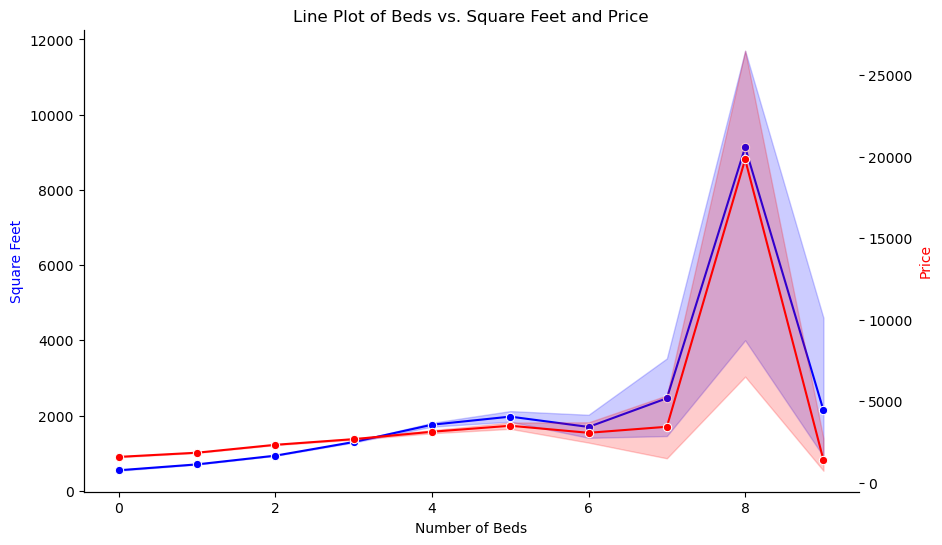

In [24]:
# Two plots represent the relationship of beds with sq_feet and beds with price
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot number of beds against square feet
sns.lineplot(x='beds', y='sq_feet', data=df, ax=ax1, color='blue', ci=95, marker='o')
ax1.set_xlabel('Number of Beds')
ax1.set_ylabel('Square Feet', color='blue')

# Plot number of beds against price
ax2 = ax1.twinx()
sns.lineplot(x='beds', y='price', data=df, ax=ax2, color='red', ci=95, marker='o')
ax2.set_ylabel('Price', color='red')

plt.title('Line Plot of Beds vs. Square Feet and Price')
sns.despine()
plt.show()

As the number of beds (x) increases, both square footage and price exhibit a similar upward trend, indicating a positive correlation between the number of beds and square footage. This correlation could potentially lead to multicollinearity in the regression model.

The shaded area in the plot represents the 95% confidence interval. At 8 beds, the ranges for both price and square footage are notably wider, which may distort the overall trend and affect the model's accuracy.

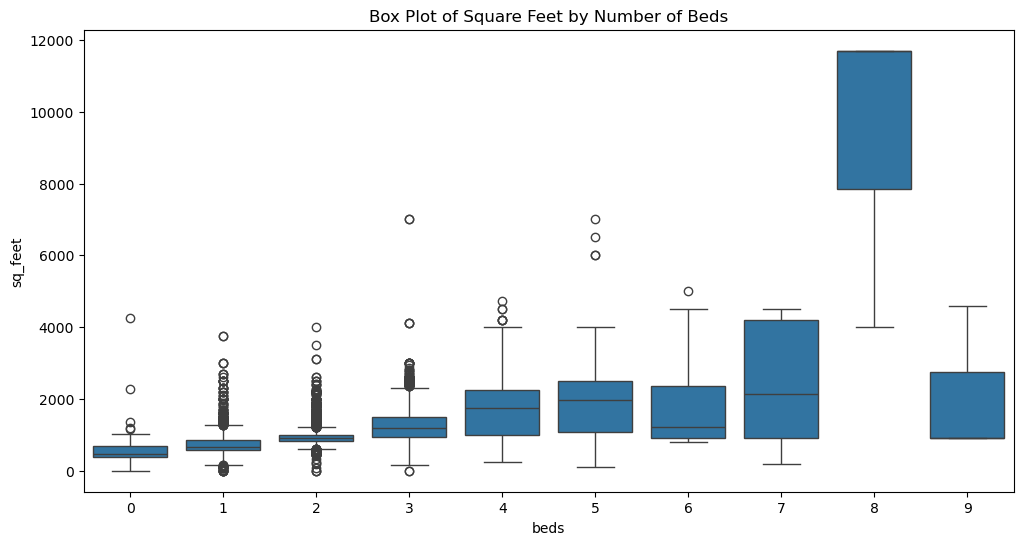

In [26]:
plt.figure(figsize=(12, 6))
#Create a box plot for 'sq_feet' against 'beds'
sns.boxplot(x='beds', y='sq_feet', data=df)
plt.title('Box Plot of Square Feet by Number of Beds')
plt.show()

From the boxplot, it is evident that there are numerous outliers in the data, particularly for properties with no bedrooms, which exhibit significant variability in size. This variability may be attributed to different property types, such as Main floor or Office, which do not follow the typical trend where more bedrooms generally correlate with increased square footage. To address this, incorporating other factors and interaction terms in the analysis could help mitigate the impact of these outliers and provide a more accurate model.

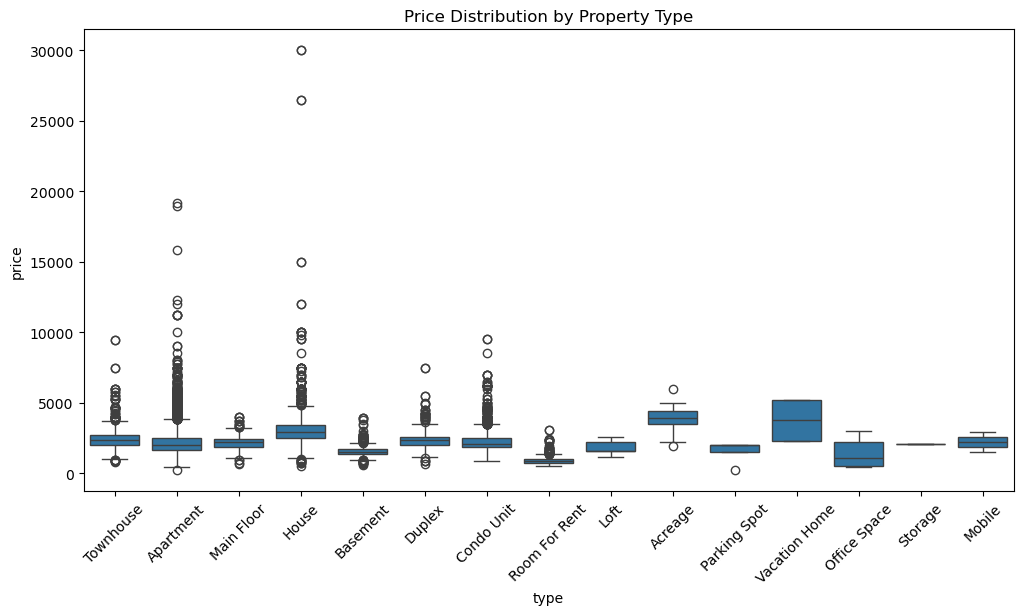

In [28]:
# Box plot for price by type of properties
plt.figure(figsize=(12, 6))
sns.boxplot(x='type', y='price', data=df)
plt.xticks(rotation=45)
plt.title('Price Distribution by Property Type')
plt.show()

From the boxplot, for residential properties (Townhouse, Apartment, Condo unit, Duplex, Loft), the middle 50% of prices range between CAD 2,000 and CAD 3,000. This range represents a typical price range for these types of properties. Notably, in the Apartment segment, the presence of outliers increases the variability of prices, which may be influenced by the lease_term, sq_feet, or other factors.

50% of the House rental prices are generally higher than those of residential properties. Vacation home rental prices range between CAD 4,000 and CAD 5,500, reflecting a premium for short-term stays, it may have positive correlation to lease_term in short time period. 

Room rentals and basement rentals typically have lower prices, around CAD 1,000, which may be due to shared kitchen and bathroom facilities. 

Parking spots and storage rentals have the lowest rent prices, reflecting their functionality and limited size.


### 2.Prepare Data

C:\Users\Zixian Ye\AppData\Local\Temp\ipykernel_7600\1032740024.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(correlation_matrix, legend=False, palette='viridis')


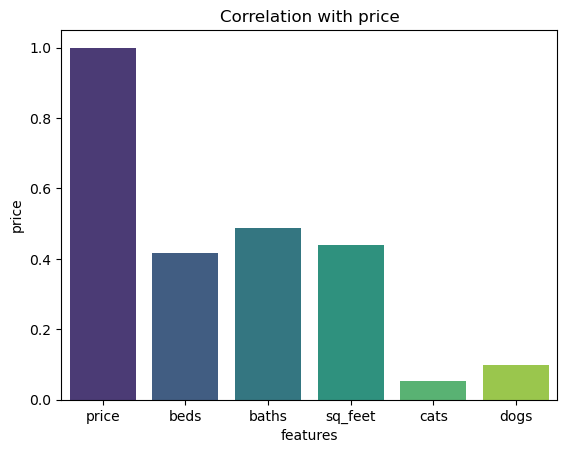

In [31]:
# Check the correlation with price in the barplot

# Set correlation matrix
correlation_matrix = df.corr(numeric_only=True)['price']

# Create a barplot of the correlations
sns.barplot(correlation_matrix, legend=False, palette='viridis')
plt.xlabel('features')
plt.title('Correlation with price')

# Show the plot
plt.show()

# Baths, beds, and sq_feet are moderately positive in price.

#### Transform categorical columns into numerical format

In [33]:
# Start with easy cols, drop 'city', 'type', 'lease_term', 'smoking' cols
df_poly = df.drop(['city', 'type', 'lease_term', 'furnishing', 'smoking'], axis=1).reset_index(drop=True)

In [34]:
df_poly.columns

Index(['province', 'price', 'beds', 'baths', 'sq_feet', 'cats', 'dogs'], dtype='object')

In [35]:
# create instance of OneHotEncoder
enc = OneHotEncoder(sparse_output=False)

# Fit and transform the enconder on the categorical columns
encoder_cols = enc.fit_transform(df_poly[['cats', 'dogs']])

# Create a new df with the encoded cols
df1 = pd.DataFrame(encoder_cols, columns = enc.get_feature_names_out(['cats', 'dogs']))

# Drop the original cols
df_poly = df_poly.drop(columns=['cats', 'dogs'])

# Join the new df into the original df
df_encoded = df_poly.join(df1)

In [36]:
df_encoded.columns

Index(['province', 'price', 'beds', 'baths', 'sq_feet', 'cats_False',
       'cats_True', 'dogs_False', 'dogs_True'],
      dtype='object')

##### Combine cats and dogs columns as pets_allowed

In [38]:
# Convert cols to int and fill nan with 0
df_encoded['cats_True'] = df_encoded['cats_True'].fillna(0).astype(int)
df_encoded['dogs_True'] = df_encoded['dogs_True'].fillna(0).astype(int)

# Combine cols
df_encoded['pets_allowed'] = df_encoded['cats_True'] | df_encoded['dogs_True']

# Drop original cats and dogs cols
df_encoded = df_encoded.drop(columns=['cats_True', 'cats_False', 'dogs_True', 'dogs_False'])


##### Check the information with beds == 8

In [40]:
# fliter the df with beds == 8
filtered_df = df[df['beds'] == 8]

# Get the infor with price, sq_feet, and beds
filtered_df[['price', 'sq_feet', 'beds']].describe()

,price,sq_feet,beds
count,3.000000,3.000000,3.0
mean,19833.333333,9133.333333,8.0
std,11547.005384,4445.597073,0.0
min,6500.000000,4000.000000,8.0
25%,16500.000000,7850.000000,8.0
50%,26500.000000,11700.000000,8.0
75%,26500.000000,11700.000000,8.0
max,26500.000000,11700.000000,8.0


Starting from the first plot, which represents the relationship of Beds vs. Square Feet and Price, and we noticed when the number of beds = 8, the price and sq_feet all have a big increase. According to the information above, when the number of beds = 8, we have the following stats:

- price std: 11547
- sq_feet std: 4445.59
- count of bed=8 : 3
  
In conclude, since there are only 3 counts of 8 beds, which explains why the standard deviation of price in beds=8 is relatively high, and also it's less reliable to interpret.

##### Create dummy variables for province column

In [43]:
# Province is one of the important features to include in predicting our target y

# get the unique values 
df_encoded['province'].unique()

array(['Alberta', 'British Columbia', 'Manitoba', 'New Brunswick',
       'Newfoundland and Labrador', 'Nova Scotia',
       'Northwest Territories', 'Ontario', 'Quebec', 'Saskatchewan'],
      dtype=object)

In [44]:
# Create dummy variables manually for the 'province' col
df_encoded = df_encoded.assign(
    Alberta=np.where(df['province'] == 'Alberta', 1, 0),
    British_Columbia=np.where(df['province'] == 'British Columbia', 1, 0),
    Manitoba=np.where(df['province'] == 'Manitoba', 1, 0),
    New_Brunswick=np.where(df['province'] == 'New Brunswick', 1, 0),
    Newfoundland_and_Labrador=np.where(df['province'] == 'Newfoundland and Labrador', 1, 0),
    Nova_Scotia=np.where(df['province'] == 'Nova Scotia', 1, 0),
    Northwest_Territories=np.where(df['province'] == 'Northwest Territories', 1, 0),
    Ontario=np.where(df['province'] == 'Ontario', 1, 0),
    Quebec=np.where(df['province'] == 'Quebec', 1, 0),
    Saskatchewan=np.where(df['province'] == 'Saskatchewan', 1, 0))

# drop the original 'province' col
df_encoded = df_encoded.drop(columns='province')

In [45]:
df_encoded.columns

Index(['price', 'beds', 'baths', 'sq_feet', 'pets_allowed', 'Alberta',
       'British_Columbia', 'Manitoba', 'New_Brunswick',
       'Newfoundland_and_Labrador', 'Nova_Scotia', 'Northwest_Territories',
       'Ontario', 'Quebec', 'Saskatchewan'],
      dtype='object')

In [46]:
# Separate X and y features

# Independent features X
X = df_encoded.drop('price', axis=1)

# Target variable y
y = df_encoded['price']

### 1. First Model - Polynomial Regression

In [48]:
# Train_test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Initialize PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False) 

#Initialize the model
model = LinearRegression()

# Create a list to be applied in pipeline sequence
operations = [('scaler', scaler), ('poly', poly), ('model', model)]

pipe =Pipeline(operations)

# Fit the model
pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('model', LinearRegression())])

In [50]:
# Predict the y values
y_pred = pipe.predict(X_test)

# Obtain the metrics
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
R2_scores = r2_score(y_test, y_pred)

print('Mean Absolute Error (MAE):', MAE)
print('Mean Squared Error (MSE):', MSE)
print('Root Mean Squared Error (RMSE):', RMSE)
print('R-squared:', R2_scores)

Mean Absolute Error (MAE): 420.3079519962709
Mean Squared Error (MSE): 398003.2373579859
Root Mean Squared Error (RMSE): 630.8749775969768
R-squared: 0.4432841684019905


### 2. Second Model - LassoCV

In the second model, I will include interaction terms between residential property types ('Townhouse', 'Apartment', 'Main Floor', 'House', 'Basement', 'Duplex', 'Condo Unit', 'Room For Rent', 'Loft') and square footage. This approach is useful for capturing how the value of a square foot may vary across different property types. 
The approach involves:

1. Creating dummy variables for property types.
2. Generating interaction terms by multiplying each dummy variable by square footage.
3. Including these interaction terms in the model.

In [53]:
# Get the type unqiue values
df['type'].unique()

array(['Townhouse', 'Apartment', 'Main Floor', 'House', 'Basement',
       'Duplex', 'Condo Unit', 'Room For Rent', 'Loft', 'Acreage',
       'Parking Spot', 'Vacation Home', 'Office Space', 'Storage',
       'Mobile'], dtype=object)

##### Create dummy variables for type of property

In [55]:
# Marge a new df with 'type' col
df_enc = df_encoded.merge(df[['price','type']], on='price', how='left')

In [56]:
df_enc.columns

Index(['price', 'beds', 'baths', 'sq_feet', 'pets_allowed', 'Alberta',
       'British_Columbia', 'Manitoba', 'New_Brunswick',
       'Newfoundland_and_Labrador', 'Nova_Scotia', 'Northwest_Territories',
       'Ontario', 'Quebec', 'Saskatchewan', 'type'],
      dtype='object')

In [57]:
# Create dummy variables manually for type of property
df_enc = df_enc.assign(
    Townhouse=np.where(df_enc['type'] == 'Townhouse', 1, 0),
    Apartment=np.where(df_enc['type'] == 'Apartment', 1, 0),
    Main_Floor=np.where(df_enc['type'] == 'Main Floor', 1, 0),
    House=np.where(df_enc['type'] == 'House', 1, 0),
    Basement=np.where(df_enc['type'] == 'Basement', 1, 0),
    Duplex=np.where(df_enc['type'] == 'Duplex', 1, 0),
    Condo_Unit=np.where(df_enc['type'] == 'Condo Unit', 1, 0),
    Room_For_Rent=np.where(df_enc['type'] == 'Room For Rent', 1, 0),
    Loft=np.where(df_enc['type'] == 'Loft', 1, 0),
    Acreage=np.where(df_enc['type'] == 'Acreage', 1, 0),
    Parking_Spot=np.where(df_enc['type'] == 'Parking Spot', 1, 0),
    Vacation_Home=np.where(df_enc['type'] == 'Vacation Home', 1, 0),
    Office_Space=np.where(df_enc['type'] == 'Office Space', 1, 0),
    Storage=np.where(df_enc['type'] == 'Storage', 1, 0),
    Mobile=np.where(df_enc['type'] == 'Mobile', 1, 0))

df_enc = df_enc.drop(columns=['type'])

In [58]:
# Separate X and y features in LassoCV

# Independent features X
X_lasso = df_enc.drop('price', axis=1)

# Target variable y
y_lasso = df_enc['price']

In [59]:
# Train_test split 
X_lasso_train, X_lasso_test, y_lasso_train, y_lasso_test = train_test_split(
    X_lasso, y_lasso, test_size=0.2, random_state=42)

In [60]:
from sklearn.linear_model import LassoCV

# Initialize the StandardScaler
scaler = StandardScaler()

# Initialize model
lassocv_model = LassoCV(eps=0.01, n_alphas=200, cv=5) 

# Create a list to be applied in pipeline sequence
operations = [('scaler', scaler), ('lassocv_model', lassocv_model)]

lasso = Pipeline(operations)

# Fit the model
lasso.fit(X_lasso_train, y_lasso_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lassocv_model', LassoCV(cv=5, eps=0.01, n_alphas=200))])

In [61]:
# Evaluate lassocv model

y_lasso_pred = lasso.predict(X_lasso_test)

# Obtain metrics

MAE = mean_absolute_error(y_lasso_test, y_lasso_pred)
MSE = mean_squared_error(y_lasso_test, y_lasso_pred)
RMSE = np.sqrt(MSE)
R2_scores = r2_score(y_test, y_pred)

print('Mean Absolute Error (MAE):', MAE)
print('Mean Squared Error (MSE):', MSE)
print('Root Mean Squared Error (RMSE):', RMSE)
print('R-squared:', R2_scores)

Mean Absolute Error (MAE): 262.04055718815357
Mean Squared Error (MSE): 133810.53652155033
Root Mean Squared Error (RMSE): 365.8012254237953
R-squared: 0.4432841684019905


### 3. Third Model - RidgeCV

In [63]:
# Create instance of RidgeCV model
ridgecv_model = RidgeCV((0.1, 1.0, 10.0), scoring='neg_mean_absolute_error')

# Fit the model on X_train_scale
ridgecv_model.fit(X_lasso_train, y_lasso_train)

RidgeCV(scoring='neg_mean_absolute_error')

In [64]:
# Evaluate ridgecv model

y_pred = ridgecv_model.predict(X_lasso_test)

# Obtain metrics
MAE = mean_absolute_error(y_lasso_test, y_pred)
MSE = mean_squared_error(y_lasso_test, y_pred)
RMSE = np.sqrt(MSE)
R2_scores = r2_score(y_lasso_test, y_pred)

print('Mean Absolute Error (MAE):', MAE)
print('Mean Squared Error (MSE):', MSE)
print('Root Mean Squared Error (RMSE):', RMSE)
print('R-squared:', R2_scores)

Mean Absolute Error (MAE): 262.3519369751238
Mean Squared Error (MSE): 133714.3633080602
Root Mean Squared Error (RMSE): 365.6697462302018
R-squared: 0.5002520766842249


### Model Evaluation

***Summary***

Polynomial Regression metrics:
- MAE : 420.31
- RMSE : 630.87
- R2_scores: 0.443

LassoCV metrics:
- MAE : 262.04
- RMSE : 365.80
- R2_scores: 0.4432

RidgeCV metrics:
- MAE : 262.35
- RMSE : 365.67
- R2_scores: 0.5002

**Observations:**
+ Addition of Property Type Columns: Including property type columns significantly reduced the RMSE and MAE, highlighting their importance in predicting rent prices.
+ Best Performing Model: RidgeCV outperformed both Polynomial Regression and LassoCV, achieving the lowest RMSE (365.67) and the highest R2 score (0.5002).

**Conclusions:**
RidgeCV, with the inclusion of property type columns, provided the best results for predicting rent prices, will be the final model to predict

### Prediction on new data 

In [71]:
new_data={
    'province': 'Ontario',
    'lease_term':'Long Term',
    'type' :'Town House',
    'beds' : 3,
    'baths' : 3.5,
    'sq_feet' :1300,
    'pets_allowed': 1,
}

In [73]:
# Convert dic to df 
new_data_df = pd.DataFrame([new_data])

# One-hot encode the categorical columns
new_data_encoded = pd.get_dummies(new_data_df, columns=['province', 'lease_term', 'type'])

# Define the expected column names by using X_lasso_train.columns
expected_cols = X_lasso_train.columns

# Add any missing columns with default values (0)
for col in expected_cols:
    if col not in new_data_encoded.columns:
        new_data_encoded[col] = 0
        
# Ensure the columns are in the correct order
new_data_encoded = new_data_encoded[expected_cols]

In [75]:
#Predict!
prediction= ridgecv_model.predict(new_data_encoded)

print('Rent:', prediction)

Rent: [2756.12844044]


In [ ]:
# Given by price = 2445, it's a bit overpriced

# The END